<a href="https://colab.research.google.com/github/risay7/Quantitative-Macroeconomics-2/blob/main/quantitative_macroeconomics_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

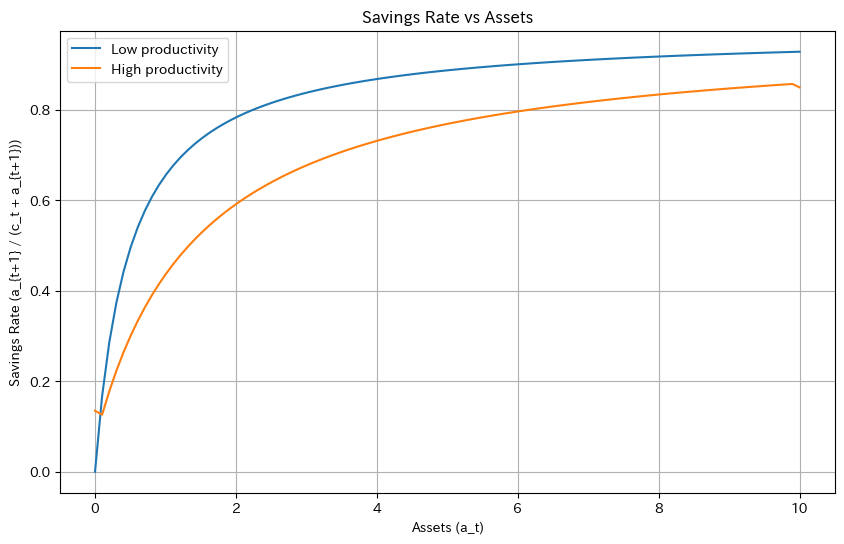

<Figure size 640x480 with 0 Axes>

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def setPar():
    param = {
        'NA': 100,  # Number of asset grid points
        'NH': 2,    # Number of productivity states
        'h': np.array([0.5, 1.5]),  # Productivity levels
        'a_l': 0,   # Lower bound of asset grid
        'a_u': 10,  # Upper bound of asset grid
        'sigma': 2, # Risk aversion coefficient
        'beta': 0.96, # Discount factor
        'pi': np.array([[0.9, 0.1], [0.1, 0.9]]) # Transition matrix
    }
    return param

def solve_household_with_tax(param, tau_r, r=0.04, w=1):
    NA = param['NA']
    NH = param['NH']
    h = param['h']
    a_l = param['a_l']
    a_u = param['a_u']
    sigma = param['sigma']
    beta = param['beta']
    pi = param['pi']
    a = np.linspace(a_l, a_u, NA)
    v = np.zeros((NA, NH))
    c = np.zeros((NA, NH))
    aplus = np.zeros((NA, NH))
    v_new = np.zeros((NA, NH))
    iaplus = np.full((NA, NH), -10000)
    util = np.full((NA, NA, NH), -10000.0)

    # Utility function calculation
    for ia in range(NA):
        for ih in range(NH):
            for iap in range(NA):
                cons = w * h[ih] + (1.0 + (1 - tau_r) * r) * a[ia] - a[iap]
                if cons > 0:
                    util[iap, ia, ih] = cons**(1.0 - sigma) / (1.0 - sigma)

    tol = 1e-6
    test = 10.0
    reward = np.zeros((NA, NA, NH))

    # Dynamic programming optimization
    while test > tol:
        for ia in range(NA):
            for ih in range(NH):
                reward[:, ia, ih] = util[:, ia, ih]
                for ihp in range(NH):
                    reward[:, ia, ih] += beta * pi[ih, ihp] * v[:, ihp]
                v_new[ia, ih] = np.max(reward[:, ia, ih])
                iaplus[ia, ih] = np.argmax(reward[:, ia, ih])
        test = np.max(abs(v_new - v))
        v = v_new
    aplus = a[iaplus]

    # Consumption calculation
    for ia in range(NA):
        for ih in range(NH):
            c[ia, ih] = w * h[ih] + (1.0 + (1 - tau_r) * r) * a[ia] - aplus[ia, ih]
    return aplus, iaplus, c

param = setPar()
tau_r = 0.3  # Set capital income tax rate
aplus_tax, iaplus_tax, c_tax = solve_household_with_tax(param, tau_r)
a = np.linspace(param['a_l'], param['a_u'], param['NA'])

# Plotting the graph (smoothly)
plt.figure(figsize=(10, 6))
plt.plot(a, aplus_tax[:, 0] / (c_tax[:, 0] + aplus_tax[:, 0]), label='Low productivity', linestyle='-', marker=None)
plt.plot(a, aplus_tax[:, 1] / (c_tax[:, 1] + aplus_tax[:, 1]), label='High productivity', linestyle='-', marker=None)
plt.xlabel("Assets (a_t)")
plt.ylabel("Savings Rate (a_{t+1} / (c_t + a_{t+1}))")
plt.title("Savings Rate vs Assets")
plt.legend()
plt.grid(True)
plt.show()

plt.savefig('savings_rate_vs_assets.png')

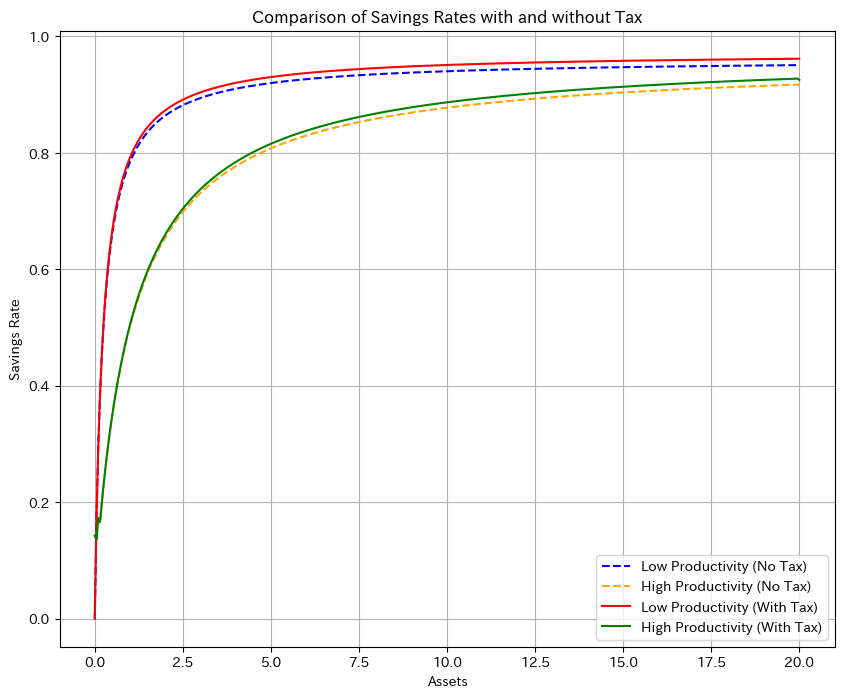

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# パラメータの設定
def setPar(sigma=1.5, beta=0.98, rho=0.6, sigma_eps=0.6, a_l=0, a_u=20, NA=401, NH=2, mu_h=-0.7, alpha=0.25, delta=0.03):
    pi, h = tauchen(NH, mu_h, rho, sigma_eps)
    h = np.exp(h)
    param = {
        'sigma': sigma, 'beta': beta, 'pi': pi, 'h': h, 'NA': NA, 'NH': NH,
        'a_l': a_l, 'a_u': a_u, 'alpha': alpha, 'delta': delta
    }
    return param

def tauchen(n, mu, rho, sigma):
    m = 1 / np.sqrt(1 - rho**2)
    state_space = np.linspace(mu - m*sigma, mu + m*sigma, n)
    d = (state_space[n-1] - state_space[0]) / (n-1)
    transition_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if j == 0:
                transition_matrix[i, 0] = norm.cdf((state_space[0] - rho*state_space[i] + d/2) / sigma)
            elif j == n-1:
                transition_matrix[i, n-1] = 1.0 - norm.cdf((state_space[n-1] - rho*state_space[i] - d/2) / sigma)
            else:
                transition_matrix[i, j] = norm.cdf((state_space[j] - rho*state_space[i] + d/2) / sigma) - norm.cdf((state_space[j] - rho*state_space[i] - d/2) / sigma)
    return transition_matrix, state_space

# 家計問題の解法（税率なし）
def solve_household_with_tax(param, r, w, tau_k):
    NA = param['NA']
    NH = param['NH']
    h = param['h']
    a_l = param['a_l']
    a_u = param['a_u']
    sigma = param['sigma']
    beta = param['beta']
    pi = param['pi']

    a = np.linspace(a_l, a_u, NA)
    util = np.full((NA, NA, NH), -10000.0)
    for ia in range(NA):
        for ih in range(NH):
            for iap in range(NA):
                cons = w * h[ih] + (1.0 + (1.0 - tau_k) * r) * a[ia] - a[iap]
                if cons > 0:
                    util[iap, ia, ih] = cons**(1.0-sigma) / (1.0-sigma)
    v = np.zeros((NA, NH))
    v_new = np.zeros((NA, NH))
    iaplus = np.full((NA, NH), -10000)
    tol = 1e-6
    test = 10.0
    while test > tol:
        for ia in range(NA):
            for ih in range(NH):
                reward = util[:, ia, ih]
                for ihp in range(NH):
                    reward += beta * pi[ih, ihp] * v[:, ihp]
                v_new[ia, ih] = np.max(reward)
                iaplus[ia, ih] = np.argmax(reward)
        test = np.max(np.abs(v_new - v))
        v = v_new
    aplus = a[iaplus]
    c = np.zeros((NA, NH))
    for ia in range(NA):
        for ih in range(NH):
            c[ia, ih] = w * h[ih] + (1.0 + (1.0 - tau_k) * r) * a[ia] - aplus[ia, ih]
    return aplus, iaplus, c

# 主な変数のプロット
def plot_combined_results(aplus_no_tax, c_no_tax, aplus_with_tax, c_with_tax, a):
    plt.figure(figsize=(10, 8))
    plt.plot(a, aplus_no_tax[:, 0] / (c_no_tax[:, 0] + aplus_no_tax[:, 0]), label='Low Productivity (No Tax)', linestyle='--', color='blue')
    plt.plot(a, aplus_no_tax[:, 1] / (c_no_tax[:, 1] + aplus_no_tax[:, 1]), label='High Productivity (No Tax)', linestyle='--', color='orange')
    plt.plot(a, aplus_with_tax[:, 0] / (c_with_tax[:, 0] + aplus_with_tax[:, 0]), label='Low Productivity (With Tax)', linestyle='-', color='red')
    plt.plot(a, aplus_with_tax[:, 1] / (c_with_tax[:, 1] + aplus_with_tax[:, 1]), label='High Productivity (With Tax)', linestyle='-', color='green')
    plt.xlabel("Assets")
    plt.ylabel("Savings Rate")
    plt.title("Comparison of Savings Rates with and without Tax")
    plt.legend()
    plt.grid(True)
    plt.show()

# パラメータ設定
param = setPar()
# 金利と賃金の設定
r, w = 0.04, 1
tau_k = 0.3

# 家計問題の解法（税率なし）
aplus_no_tax, iaplus_no_tax, c_no_tax = solve_household_with_tax(param, r, w, 0.0)
# 家計問題の解法（税率あり）
aplus_with_tax, iaplus_with_tax, c_with_tax = solve_household_with_tax(param, r, w, tau_k)

# 結果のプロット
a = np.linspace(param['a_l'], param['a_u'], param['NA'])
plot_combined_results(aplus_no_tax, c_no_tax, aplus_with_tax, c_with_tax, a)

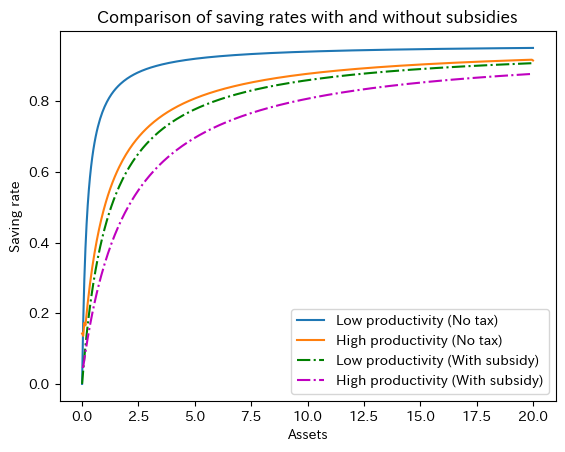

In [17]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import japanize_matplotlib

# Discretization of Markov process
def tauchen(n, mu, rho, sigma):
    m = 1 / np.sqrt(1 - rho**2)
    state_space = np.linspace(mu - m*sigma, mu + m*sigma, n)
    d = (state_space[-1] - state_space[0]) / (n - 1)
    transition_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if j == 0:
                transition_matrix[i, j] = norm.cdf((state_space[0] - rho * state_space[i] + d / 2) / sigma)
            elif j == n - 1:
                transition_matrix[i, j] = 1.0 - norm.cdf((state_space[-1] - rho * state_space[i] - d / 2) / sigma)
            else:
                transition_matrix[i, j] = norm.cdf((state_space[j] - rho * state_space[i] + d / 2) / sigma) - norm.cdf((state_space[j] - rho * state_space[i] - d / 2) / sigma)
    return transition_matrix, state_space

# Parameter settings
def setPar(
    sigma=1.5, beta=0.98, rho=0.6, sigma_eps=0.6, a_l=0, a_u=20, NA=401, NH=2, mu_h=-0.7, alpha=0.25, delta=0.03):
    pi, h = tauchen(NH, mu_h, rho, sigma_eps)
    h = np.exp(h)
    param = {
        'sigma': sigma, 'beta': beta, 'pi': pi, 'h': h, 'NA': NA, 'NH': NH,
        'a_l': a_l, 'a_u': a_u, 'alpha': alpha, 'delta': delta
    }
    return param

# Solving household problem (considering subsidies)
def solve_household_with_transfer(param, r, w, T):
    NA = param['NA']
    NH = param['NH']
    h = param['h']
    a_l = param['a_l']
    a_u = param['a_u']
    sigma = param['sigma']
    beta = param['beta']
    pi = param['pi']

    a = np.linspace(a_l, a_u, NA)
    util = np.full((NA, NA, NH), -10000.0)
    for ia in range(NA):
        for ih in range(NH):
            for iap in range(NA):
                cons = w * h[ih] + (1.0 + r) * a[ia] - a[iap] + T
                if cons > 0:
                    util[iap, ia, ih] = cons**(1.0-sigma) / (1.0-sigma)
    v = np.zeros((NA, NH))
    v_new = np.zeros((NA, NH))
    iaplus = np.full((NA, NH), -10000)
    tol = 1e-6
    test = 10.0
    while test > tol:
        for ia in range(NA):
            for ih in range(NH):
                reward = util[:, ia, ih]
                for ihp in range(NH):
                    reward += beta * pi[ih, ihp] * v[:, ihp]
                v_new[ia, ih] = np.max(reward)
                iaplus[ia, ih] = np.argmax(reward)
        test = np.max(np.abs(v_new - v))
        v = v_new
    aplus = a[iaplus]
    c = np.zeros((NA, NH))
    for ia in range(NA):
        for ih in range(NH):
            c[ia, ih] = w * h[ih] + (1.0 + r) * a[ia] - aplus[ia, ih] + T
    return aplus, iaplus, c

# Plotting key variables
def plot_combined_results(aplus_no_tax, c_no_tax, aplus_with_transfer, c_with_transfer, a):
    plt.plot(a, aplus_no_tax[:, 0] / (c_no_tax[:, 0] + aplus_no_tax[:, 0]), label='Low productivity (No tax)')
    plt.plot(a, aplus_no_tax[:, 1] / (c_no_tax[:, 1] + aplus_no_tax[:, 1]), label='High productivity (No tax)')
    plt.plot(a, aplus_with_transfer[:, 0] / (c_with_transfer[:, 0] + aplus_with_transfer[:, 0]), 'g-.', label='Low productivity (With subsidy)')
    plt.plot(a, aplus_with_transfer[:, 1] / (c_with_transfer[:, 1] + aplus_with_transfer[:, 1]), 'm-.', label='High productivity (With subsidy)')
    plt.xlabel("Assets")
    plt.ylabel("Saving rate")
    plt.title("Comparison of saving rates with and without subsidies")
    plt.legend()
    plt.show()

# Parameter settings
param = setPar()
# Setting interest rate and wages
r, w = 0.04, 1
T = 1  # Amount of subsidy

# Solving household problem (no tax)
aplus_no_tax, iaplus_no_tax, c_no_tax = solve_household_with_transfer(param, r, w, 0.0)
# Solving household problem (with subsidy)
aplus_with_transfer, iaplus_with_transfer, c_with_transfer = solve_household_with_transfer(param, r, w, T)

# Plotting results
a = np.linspace(param['a_l'], param['a_u'], param['NA'])
plot_combined_results(aplus_no_tax, c_no_tax, aplus_with_transfer, c_with_transfer, a)

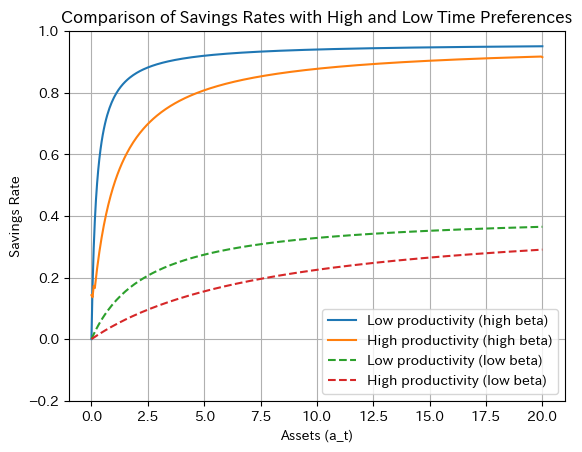

In [18]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# Parameter setting
def setPar(sigma=1.5, beta=0.98, rho=0.6, sigma_eps=0.6, a_l=0, a_u=20, NA=401, NH=2, mu_h=-0.7, alpha=0.25, delta=0.03):
    pi, h = tauchen(NH, mu_h, rho, sigma_eps)
    h = np.exp(h)
    param = {
        'sigma': sigma, 'beta': beta, 'pi': pi, 'h': h, 'NA': NA, 'NH': NH,
        'a_l': a_l, 'a_u': a_u, 'alpha': alpha, 'delta': delta
    }
    return param

# Solving the household problem
def solve_household(param, r, w):
    NA = param['NA']
    NH = param['NH']
    h = param['h']
    a_l = param['a_l']
    a_u = param['a_u']
    sigma = param['sigma']
    beta = param['beta']
    pi = param['pi']

    a = np.linspace(a_l, a_u, NA)
    util = np.full((NA, NA, NH), -10000.0)
    for ia in range(NA):
        for ih in range(NH):
            for iap in range(NA):
                cons = w * h[ih] + (1.0 + r) * a[ia] - a[iap]
                if cons > 0:
                    util[iap, ia, ih] = cons**(1.0-sigma) / (1.0-sigma)
    v = np.zeros((NA, NH))
    v_new = np.zeros((NA, NH))
    iaplus = np.full((NA, NH), -10000)
    tol = 1e-6
    test = 10.0
    while test > tol:
        for ia in range(NA):
            for ih in range(NH):
                reward = util[:, ia, ih]
                for ihp in range(NH):
                    reward += beta * pi[ih, ihp] * v[:, ihp]
                v_new[ia, ih] = np.max(reward)
                iaplus[ia, ih] = np.argmax(reward)
        test = np.max(np.abs(v_new - v))
        v = v_new
    aplus = a[iaplus]
    c = np.zeros((NA, NH))
    for ia in range(NA):
        for ih in range(NH):
            c[ia, ih] = w * h[ih] + (1.0 + r) * a[ia] - aplus[ia, ih]
    return aplus, iaplus, c

# Setting parameters
sigma = 1.5
beta_low = 0.1
rho = 0.6
sigma_e = 0.6
r = 0.04
w = 1

# Productivity setting
h_L = np.exp(-sigma_e)
h_H = np.exp(sigma_e)

# Setting a wide range of asset grid
a_t_grid = np.linspace(0, 20, 200)

# Calculation of saving rate (low time preference rate)
def calc_saving_rate_low_beta(a_t, h):
    c_t = w * h + (1 + r) * a_t - a_t / (1 + beta_low)
    a_t_plus_1 = beta_low * (w * h + (1 + r) * a_t - c_t)
    saving_rate = a_t_plus_1 / (c_t + a_t_plus_1)
    return saving_rate

saving_rate_L_low_beta = [calc_saving_rate_low_beta(a, h_L) for a in a_t_grid]
saving_rate_H_low_beta = [calc_saving_rate_low_beta(a, h_H) for a in a_t_grid]

# Plotting the main variables
def plot_results(aplus_high, c_high, aplus_low, c_low, a):
    plt.plot(a, aplus_high[:, 0] / (c_high[:, 0] + aplus_high[:, 0]), label='Low productivity (high beta)', linestyle='-')
    plt.plot(a, aplus_high[:, 1] / (c_high[:, 1] + aplus_high[:, 1]), label='High productivity (high beta)', linestyle='-')
    plt.plot(a_t_grid, saving_rate_L_low_beta, label='Low productivity (low beta)', linestyle='--')
    plt.plot(a_t_grid, saving_rate_H_low_beta, label='High productivity (low beta)', linestyle='--')
    plt.xlabel("Assets (a_t)")
    plt.ylabel("Savings Rate")
    plt.ylim(-0.2, 1.0)
    plt.legend()
    plt.title("Comparison of Savings Rates with High and Low Time Preferences")
    plt.grid(True)
    plt.show()

# Setting parameters (high time preference rate)
param_high = setPar(beta=0.98)
# Setting parameters (low time preference rate)
param_low = setPar(beta=0.1)

# Setting interest rates and wages
r, w = 0.04, 1

# Solving the household problem (high time preference rate)
aplus_high, iaplus_high, c_high = solve_household(param_high, r, w)
# Solving the household problem (low time preference rate)
aplus_low, iaplus_low, c_low = solve_household(param_low, r, w)

# Plotting the results
a = np.linspace(param_high['a_l'], param_high['a_u'], param_high['NA'])
plot_results(aplus_high, c_high, aplus_low, c_low, a)

# Setting parameters
sigma = 1.5
beta = 0.98  # Adjusted beta
rho = 0.6
sigma_e = 0.6
r = 0.04  # Adjusted interest rate
w = 1
tau_k = 0.3  # Capital income tax rate

# Productivity setting
h_L = np.exp(-sigma_e)
h_H = np.exp(sigma_e)

# Setting a wide range of asset grid
a_t_grid = np.linspace(0, 20, 200)

# Calculation of saving rate (introducing capital income tax)
def calc_saving_rate_with_tax(a_t, h):
    c_t = w * h + (1 + (1 - tau_k) * r) * a_t - a_t / (1 + beta)
    a_t_plus_1 = beta * (w * h + (1 + (1 - tau_k) * r) * a_t - c_t)
    saving_rate = a_t_plus_1 / (c_t + a_t_plus_1)
    return saving_rate

saving_rate_L_tax = [calc_saving_rate_with_tax(a, h_L) for a in a_t_grid]
saving_rate_H_tax = [calc_saving_rate_with_tax(a, h_H) for a in a_t_grid]

# Previous calculation of saving rate (no tax)
def calc_saving_rate(a_t, h):
    c_t = w * h + (1 + r) * a_t - a_t / (1 + beta)
    a_t_plus_1 = beta * (w * h + (1 + r) * a_t - c_t)
    saving_rate = a_t_plus_1 / (c_t + a_t_plus_1)
    return saving_rate